# Titanic - Machine Learning from Disaster

Author: Renaud Gaudron\
Latest update: 11/10/2021

### Importing the relevant python libraries

In [57]:
# General statistical/maths libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from scipy import stats

# Data visualisation libraries
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning libraries
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import optuna


### Importing the data & cleanup

In [58]:
data_train=pd.read_csv('train.csv')
data_test=pd.read_csv('test.csv')

In [59]:
data_train.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [60]:
def cleanup(dataframe,age_mean,fare_mean):
    
    dataframe.drop(columns=['Name', 'Ticket'], inplace=True)     # Dropping unnecessary columns
    dataframe.replace(['male', 'female'], [0, 1], inplace=True)  # Replacing male/female by 0/1
    dataframe['Age'].fillna(round(age_mean,2), inplace=True)  # Filling NaN values
    dataframe['Fare'].fillna(fare_mean, inplace=True) # Filling NaN values
    
    # Determining the deck on which each cabin was located
    list1=str(list(range(0,10)))
    list2=''*10
    dataframe['Cabin']=dataframe['Cabin'].str.replace(list1, list2)
    dataframe['Cabin'].fillna('Z', inplace=True)
    n=len(dataframe['PassengerId'])
    for i in range(0,n):
        if len(dataframe.at[i,'Cabin'])>1:
            dataframe.at[i,'Cabin']=dataframe.at[i,'Cabin'][0] 
    dataframe = dataframe.join(pd.get_dummies(dataframe['Cabin'], prefix='Cabin')) # One-hot encoding of the deck
    dataframe.drop(columns=['Cabin'], inplace=True)    
    
    dataframe.set_index('PassengerId', inplace=True) # Setting PassengerId as the index
    dataframe = dataframe.join(pd.get_dummies(dataframe['Embarked'], prefix='Embarked')) # One-hot encoding of the embarkation location
    dataframe.drop(columns=['Embarked'], inplace=True)
    return dataframe

In [61]:
age_mean=(data_train['Age'].append(data_test['Age'])).mean() # Mean age across both datasets
fare_mean=(data_train['Fare'].append(data_test['Fare'])).mean() # Mean fare across both datasets

data_train=cleanup(data_train,age_mean,fare_mean)
data_test=cleanup(data_test,age_mean,fare_mean)

In [62]:
data_train.head(20)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_Z,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,,,,,
1,0,3,0,22.00,1,0,7.2500,0,0,0,0,0,0,0,0,1,0,0,1
2,1,1,1,38.00,1,0,71.2833,0,0,1,0,0,0,0,0,0,1,0,0
3,1,3,1,26.00,0,0,7.9250,0,0,0,0,0,0,0,0,1,0,0,1
4,1,1,1,35.00,1,0,53.1000,0,0,1,0,0,0,0,0,0,0,0,1
5,0,3,0,35.00,0,0,8.0500,0,0,0,0,0,0,0,0,1,0,0,1
6,0,3,0,29.88,0,0,8.4583,0,0,0,0,0,0,0,0,1,0,1,0
7,0,1,0,54.00,0,0,51.8625,0,0,0,0,1,0,0,0,0,0,0,1
8,0,3,0,2.00,3,1,21.0750,0,0,0,0,0,0,0,0,1,0,0,1
9,1,3,1,27.00,0,2,11.1333,0,0,0,0,0,0,0,0,1,0,0,1


### Exploratory data analysis

In [63]:
print(data_train.dtypes) # Checking the data types

Survived        int64
Pclass          int64
Sex             int64
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Cabin_A         uint8
Cabin_B         uint8
Cabin_C         uint8
Cabin_D         uint8
Cabin_E         uint8
Cabin_F         uint8
Cabin_G         uint8
Cabin_T         uint8
Cabin_Z         uint8
Embarked_C      uint8
Embarked_Q      uint8
Embarked_S      uint8
dtype: object


In [64]:
data_train.describe() # Checking the statistical information about each feature

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_Z,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.735051,0.523008,0.381594,32.204208,0.016835,0.052750,0.066218,0.037037,0.035915,0.014590,0.004489,0.001122,0.771044,0.188552,0.086420,0.722783
std,0.486592,0.836071,0.477990,13.002216,1.102743,0.806057,49.693429,0.128725,0.223659,0.248802,0.188959,0.186182,0.119973,0.066890,0.033501,0.420397,0.391372,0.281141,0.447876
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,29.880000,0.000000,0.000000,14.454200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [65]:
data_train['Survived'].value_counts().to_frame() # Checking the skewness of the data

,Survived
0,549
1,342


In [66]:
data_train['Pclass'].value_counts().to_frame() # Checking the skewness of the data

,Pclass
3,491
1,216
2,184


In [67]:
data_train['Sex'].value_counts().to_frame() # Checking the skewness of the data

,Sex
0,577
1,314


In [68]:
data_train['SibSp'].value_counts().to_frame() # Checking the skewness of the data

,SibSp
0,608
1,209
2,28
4,18
3,16
8,7
5,5


In [69]:
data_train['Parch'].value_counts().to_frame() # Checking the skewness of the data

,Parch
0,678
1,118
2,80
5,5
3,5
4,4
6,1


<AxesSubplot:xlabel='Survived', ylabel='Fare'>

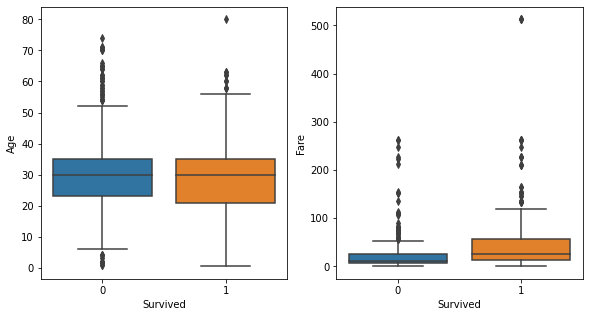

In [70]:
# Age and Fare versus survival

fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.boxplot(x="Survived", y="Age", data=data_train)
plt.subplot(1,3,2)
sns.boxplot(x="Survived", y="Fare", data=data_train)

### Selecting the features

In [73]:
Features=list(set(data_train.columns.values)-{'Survived', 'PassengerId'}) # Extracting all possible features from data_train
Best_Feat=[] # Best features (to be used by the ML algorithm)

for feature in sorted(Features):
    try:
        pearson_coef, p_value = stats.pearsonr(data_train['Survived'], data_train[feature])
        if abs(pearson_coef)>0.00 and p_value<0.1: # Select the feature only if the Pearson correlation coefficient is meaningful
            print(feature,"- Survived: the Pearson correlation coefficient is", round(pearson_coef,3), " with a P-value of", format(p_value,".3E")) 
            Best_Feat.append(feature)
    except:
        pass

Age - Survived: the Pearson correlation coefficient is -0.07  with a P-value of 3.585E-02
Cabin_B - Survived: the Pearson correlation coefficient is 0.175  with a P-value of 1.442E-07
Cabin_C - Survived: the Pearson correlation coefficient is 0.115  with a P-value of 6.062E-04
Cabin_D - Survived: the Pearson correlation coefficient is 0.151  with a P-value of 6.233E-06
Cabin_E - Survived: the Pearson correlation coefficient is 0.145  with a P-value of 1.332E-05
Cabin_F - Survived: the Pearson correlation coefficient is 0.058  with a P-value of 8.392E-02
Cabin_Z - Survived: the Pearson correlation coefficient is -0.317  with a P-value of 3.091E-22
Embarked_C - Survived: the Pearson correlation coefficient is 0.168  with a P-value of 4.397E-07
Embarked_S - Survived: the Pearson correlation coefficient is -0.156  with a P-value of 3.036E-06
Fare - Survived: the Pearson correlation coefficient is 0.257  with a P-value of 6.120E-15
Parch - Survived: the Pearson correlation coefficient is 0.

### Training the ML algorithm

In [74]:
X_norm=data_train[Best_Feat].append(data_test[Best_Feat])
X_norm=preprocessing.StandardScaler().fit(X_norm).transform(X_norm) # Feature normalisation

Y=data_train['Survived'].values # Output vector - training set
X=X_norm[0:len(Y),:] # Input matrix - training set
X_test=X_norm[len(Y):len(X_norm),:] # Input matrix - testing set

# Checking the size of the input matrices and output vector
print(Y.shape)
print(X.shape)
print(X_test.shape)

(891,)
(891, 13)
(418, 13)


In [75]:
# Random forest algorithm with an automatic hyperparameter optimisation tool (optuna)

clf = RandomForestClassifier(criterion='gini', min_samples_split=4, min_samples_leaf=2)

param_distributions = {
    "ccp_alpha": optuna.distributions.LogUniformDistribution(1e-5, 1e-1),
    "n_estimators": optuna.distributions.IntUniformDistribution(1, 600),  
    "max_depth": optuna.distributions.IntUniformDistribution(1, 10),
}

optuna_search = optuna.integration.OptunaSearchCV(
    clf, param_distributions, n_trials=500, verbose=2, n_jobs=-1, cv=5, scoring='accuracy'
)

optuna_search.fit(X, Y)

print("Best trial:")
trial = optuna_search.study_.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
pred_GB=optuna_search.predict(X)
acc_training_GB=metrics.accuracy_score(Y,pred_GB)

print('\nAccuracy - Training set:',acc_training_GB)
print('Accuracy - CV set:',trial.value)

Y_test = optuna_search.predict(X_test) # Predict the output using the input matrix of the testing set and the model

<ipython-input-75-2b85cab5d68c>:13: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
C:\Users\Renaud\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classifier=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[I 2021-10-11 13:24:19,050] A new study created in memory with name: no-name-ed6d1226-3446-475b-bbe8-b8a59c3b9231
[I 2021-10-11 13:24:19,051] Searching the best hyperparameters using 891 samples...
C:\Users\Renaud\anaconda3\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2021-10-11 13:24:25,506] Trial 2 finished with value: 0.827179712510200

Best trial:
  Value:  0.8316929257422634
  Params: 
    ccp_alpha: 0.0006126707163181668
    n_estimators: 219
    max_depth: 5

Accuracy - Training set: 0.8439955106621774
Accuracy - CV set: 0.8316929257422634


### Writing the predictions to a file

In [76]:
final_data=np.column_stack((data_test.index.astype(int), np.transpose(Y_test).astype(int)))
np.savetxt("Prediction.csv", final_data, delimiter=",", header='PassengerId,Survived', fmt='%d', comments='')